In [1]:
import pandas as pd

## 1.	Use S&P 500 futures tick data taken from

https://www.kaggle.com/datasets/finnhub/sp-500-futures-tick-data-sp. 

Save it as SP.csv. 

Remove the rows with 0 volume and then proceed.

In [2]:
sp = pd.read_csv('../data/SP.csv')


In [3]:
# Convert time column to string format first, then combine
sp['date_time'] = pd.to_datetime(sp['date'].astype(str) + ' ' + sp['time'].astype(str))

In [4]:
# sp_process for later use
sp = sp[['date_time', 'price', 'volume']].copy()

In [5]:
sp = sp[sp['volume'] != 0]

In [6]:
sp.head()

,date_time,price,volume
2812944,2003-06-30 23:00:06,971.9,1
2812945,2003-06-30 23:00:14,972.0,1
2812946,2003-06-30 23:04:16,972.0,1
2812947,2003-06-30 23:04:34,972.0,9
2812948,2003-06-30 23:05:02,972.0,91


In [7]:
#Check for zero volume rows
print(f"Rows with Volume = 0: {(sp['volume'] == 0).sum()}")

Rows with Volume = 0: 0


### Create sp_processed and limit the data to between 2010 and 2016

In [8]:
# sp_process for later use
sp_processed = sp[['date_time', 'price', 'volume']].copy()

# Filter to only 2010-2016
sp_processed = sp_processed[(sp_processed['date_time'] >= '2010-01-01') & 
                            (sp_processed['date_time'] < '2016-01-01')]

In [9]:
from mlfinlab.data_structures import standard_data_structures
# Compare different thresholds
for threshold in [1e6, 1.5e6, 2e6, 5e6]:
    bars = standard_data_structures.get_dollar_bars(sp_processed, threshold=threshold, batch_size=1000000, verbose=False)
    print(f"Threshold ${threshold/1e6:.1f}M: {len(bars)} bars")

<frozen mlfinlab.util.fast_ewma>:17: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.


Threshold $1.0M: 3811 bars
Threshold $1.5M: 2543 bars
Threshold $2.0M: 1908 bars
Threshold $5.0M: 763 bars


### Set Threshold to $2.0 million

In [10]:
#DOLLAR BARS Using MLFinLab

dollar_bars = standard_data_structures.get_dollar_bars(
    sp_processed, threshold=2000000, batch_size=1000000, verbose=False
)

print(f"Dollar bars shape: {dollar_bars.shape}")

Dollar bars shape: (1908, 9)


In [11]:
# From GPT-5

def get_daily_vol(close, span=100, lookback=pd.Timedelta('1D')):
    # Ensure we are working with a datetime index Series
    if isinstance(close, pd.DataFrame):
        if 'close' not in close.columns:
            raise ValueError("DataFrame must have a 'close' column.")
        close = close['close']
    if 'date_time' in getattr(close, 'columns', []):
        close = close.set_index('date_time')['close']
    close = close.sort_index()
    if not isinstance(close.index, pd.DatetimeIndex):
        raise ValueError("Input series must have a DatetimeIndex.")

    prev = close.index.searchsorted(close.index - lookback)
    prev = prev[prev > 0]
    prev_ts = pd.Series(close.index[prev - 1], index=close.index[-prev.shape[0]:])
    returns = close.loc[prev_ts.index] / close.loc[prev_ts.values].values - 1
    return returns.ewm(span=span).std()

In [12]:
'''Modified Snippet 2.4 the Symetric CUSUM Filter'''
# From GPT-5
def get_t_events(price, h):
    price = price.sort_index()
    if isinstance(h, pd.Series):
        h = h.reindex(price.index)
    diff = price.diff().dropna()
    t_events, s_pos, s_neg = [], 0.0, 0.0

    for t in diff.index:
        s_pos = max(0.0, s_pos + diff.loc[t])
        s_neg = min(0.0, s_neg + diff.loc[t])
        threshold = h.loc[t] if isinstance(h, pd.Series) else h
        if pd.isna(threshold):
            continue
        if s_neg < -threshold:
            s_neg = 0.0
            t_events.append(t)
        elif s_pos > threshold:
            s_pos = 0.0
            t_events.append(t)
    return pd.DatetimeIndex(t_events)

### Get daily vol from dollar bars

In [13]:
dv_dollar = get_daily_vol(dollar_bars['close'], span=100)

### threshold_dollars is daily vol times price to match event diff units

In [14]:

threshold_dollars = dv_dollar * dollar_bars['close']
devents = get_t_events(dollar_bars['close'], threshold_dollars * 1)

In [15]:
close = dollar_bars['close']

'''Snippet 3.4 ADDING A VERTICAL BARRIER - Bar-based instead of time-based'''

numBars = 1  # Number of bars ahead, not days

# For each event, find the bar that is numBars positions ahead
t1_indices = []
t1_values = []

for event in devents:
    event_pos = close.index.get_loc(event)
    t1_pos = min(event_pos + numBars, len(close) - 1)  # Don't go past the end
    t1_indices.append(event)
    t1_values.append(close.index[t1_pos])

t1 = pd.Series(t1_values, index=t1_indices)

In [16]:
'''Snippet 3.2 TRIPPLE-BARRIER LABELING METHOD'''

def applyPtSlOnT1(close, events, ptSl, molecule):
    events_ = events.loc[molecule]
    out = events_[['t1']].copy(deep=True)
    if ptSl[0] > 0:
        pt = ptSl[0] * events_['trgt']
    else:
        pt = pd.Series(index=events.index) #NaNa
    if ptSl[1] > 0:
        sl = -ptSl[1] * events_['trgt']
    else:
        sl = pd.Series(index=events.index) #NaNa
    for loc, t1 in events_['t1'].fillna(close.index[-1]).items():
        df0 = close[loc:t1]  # path prices
        df0 = (df0 / close[loc] - 1)  # path returns
        out.loc[loc, 'sl'] = df0[df0 < sl.loc[loc]].index.min()  # earliest stop loss
        out.loc[loc, 'pt'] = df0[df0 > pt.loc[loc]].index.min()  # earliest profit taking
    return out
    

In [17]:
# Create events DataFrame
events = pd.DataFrame(index=devents)
events['t1'] = t1  # vertical barrier
events['trgt'] = dv_dollar.reindex(devents)  # target/threshold for each event

# Apply triple barrier
TripleBarrierEvents = applyPtSlOnT1(close, events, ptSl=(1, 1), molecule=devents)

In [18]:
import numpy as np
'''Snippet 3.5 LABELING FOR SIDE AND SIZE'''

def getBins(events, close):
    events_ = events.dropna(subset=['t1'])
    px = events_.index.union(events_['t1'].values).drop_duplicates()
    px = close.reindex(px, method='bfill')

    out = pd.DataFrame(index=events_.index)
    out['ret'] = px.loc[events_['t1'].values].values / px.loc[events_.index].values - 1.0
    out['bin'] = np.sign(out['ret'])
    return out


## In Chapter 3, we denoted as t1 a pandas series of timestamps where the first barrier was touched, and the index was the timestamp of the observation. This was the output of the getEvents function.
### (a)	Compute a t1 series on dollar bars derived from the S&P 500 futures tick data above.

In [19]:
# Merge TripleBarrierEvents with events to get complete information
events_complete = events.copy()
events_complete['sl'] = TripleBarrierEvents['sl']
events_complete['pt'] = TripleBarrierEvents['pt']

# Determine which barrier was touched first for each event
# The t1 column should reflect whichever barrier was hit first (or vertical barrier if nothing hit)
for idx in events_complete.index:
    barriers = [events_complete.loc[idx, 'pt'], 
                events_complete.loc[idx, 'sl'], 
                events_complete.loc[idx, 't1']]
    # Get the earliest non-NaT barrier
    barriers_valid = [b for b in barriers if pd.notna(b)]
    if barriers_valid:
        events_complete.loc[idx, 't1'] = min(barriers_valid)

# Apply getBins to generate labels
labels = getBins(events_complete, close)
#labels

### The t1 series is in the dataframe events_complete

### (b)	Apply the function mpNumCoEvents to compute the number of overlapping outcomes at each point in time.

In [31]:
import numpy as np

'''Snippet 4.1 - Estimating the Uniqueness of a Label'''
def mpNumCoEvents(closeIdx, t1, molecule):
    '''
    Computes the number of concurrent events per bar.
    +molecule[0] is the date of the first event on which the weight will be computed
    +molecule[-1] is the date of the last event on which the weight will be computed
    Any event that starts before t1[molecule].max() impacts the count.
    
    Parameters:
    -----------
    closeIdx : DatetimeIndex
        The index of all bars (e.g., dollar_bars.index)
    t1 : Series
        Series with event start times as index and barrier touch times as values
    molecule : DatetimeIndex or array-like
        Subset of event dates for which to compute concurrent events
    
    Returns:
    --------
    count : Series
        Number of concurrent events for each bar in the range
    '''
    # 1) Find events that span the period (molecule[0], molecule[-1])
    t1 = t1.fillna(closeIdx[-1])  # Fill any NaN with last bar
    t1 = t1[t1 >= molecule[0]]    # Events that end after molecule starts
    t1 = t1.loc[:t1[molecule].max()]  # Events that start before molecule ends
    
    # 2) Count events spanning a bar
    iloc = closeIdx.searchsorted(np.array([t1.index[0], t1.max()]))
    count = pd.Series(0, index=closeIdx[iloc[0]:iloc[1]+1])
    
    for tIn, tOut in t1.items():
        count.loc[tIn:tOut] += 1
    
    return count.loc[molecule[0]:t1[molecule].max()]

In [32]:
# Apply mpNumCoEvents to compute overlapping outcomes
# Use events_complete['t1'] which contains the timestamp when first barrier was touched
# The index of events_complete is the event start time

# Get the close index (all bar timestamps)
closeIdx = dollar_bars.index

# Get t1 series (event start -> barrier touch time)
t1_series = events_complete['t1'].copy()

# Compute concurrent events for all events
concurrent_events = mpNumCoEvents(closeIdx, t1_series, t1_series.index)

print(f"Concurrent events computed for {len(concurrent_events)} bars")
print(f"\nConcurrent events statistics:")
print(concurrent_events.describe())
print(f"\nMax concurrent events: {concurrent_events.max()}")
print(f"Mean concurrent events: {concurrent_events.mean():.2f}")

# Show first few concurrent event counts
print(f"\nFirst 10 concurrent event counts:")
print(concurrent_events.head(10))

Concurrent events computed for 1905 bars

Concurrent events statistics:
count    1905.000000
mean        0.563780
std         0.576364
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         2.000000
dtype: float64

Max concurrent events: 2
Mean concurrent events: 0.56

First 10 concurrent event counts:
date_time
2010-01-07 03:05:55    1
2010-01-07 23:07:48    2
2010-01-08 07:38:27    1
2010-01-11 03:28:15    1
2010-01-12 01:17:28    2
2010-01-12 06:28:58    1
2010-01-13 03:36:17    0
2010-01-14 04:54:05    0
2010-01-15 04:56:27    0
2010-01-17 21:03:50    1
dtype: int64


### (c)	Plot the time series of the number of concurrent labels on the primary axis, andthe time series of exponentially weighted moving standard deviation of returns on the secondary axis.

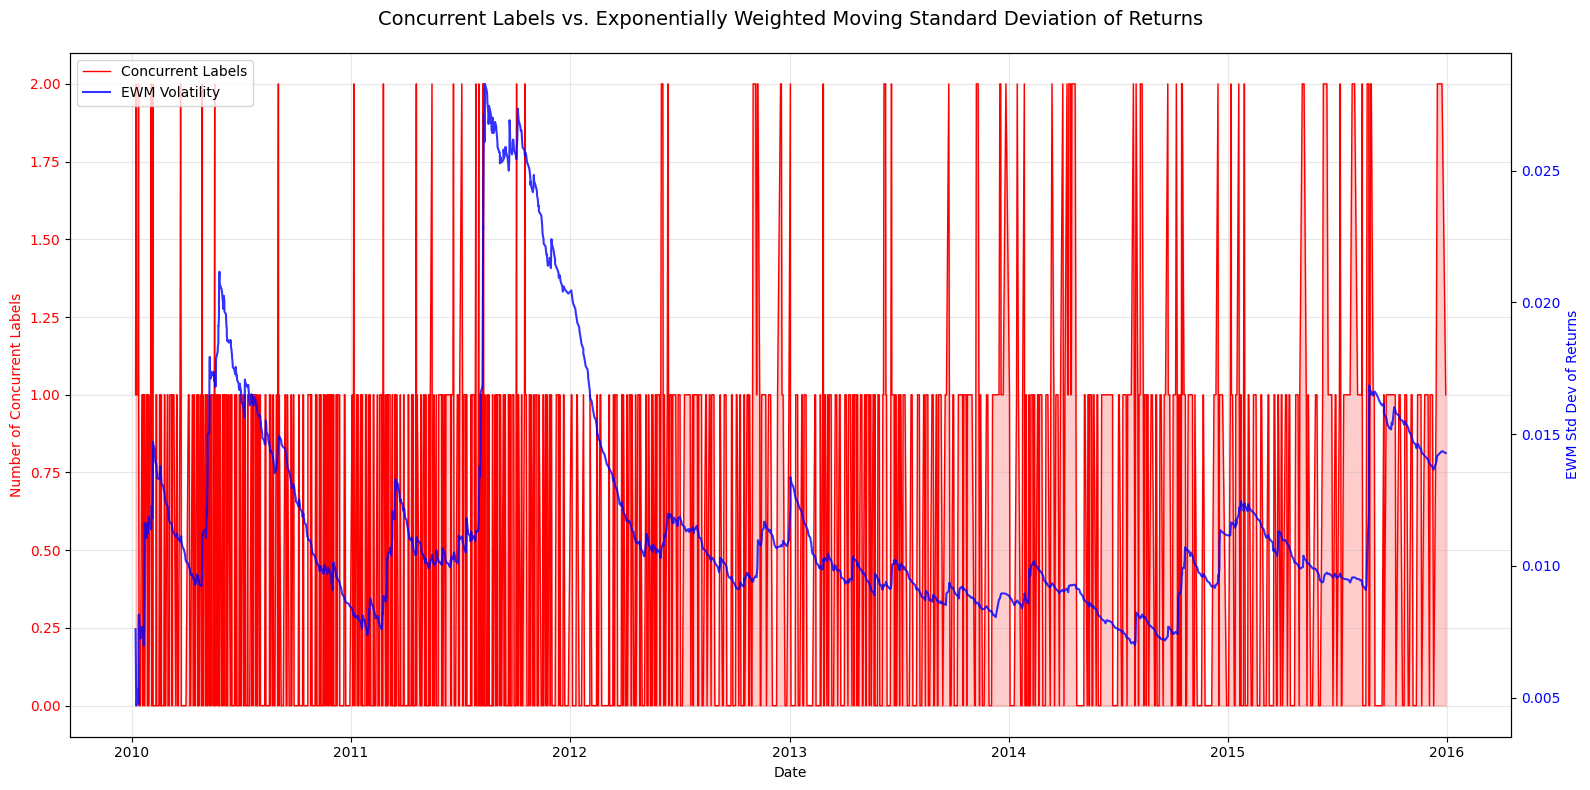

In [29]:
import matplotlib.pyplot as plt

# Plot concurrent labels and volatility on dual axes
fig, ax1 = plt.subplots(figsize=(16, 8))

# Primary axis - Concurrent Events (left y-axis)
color = 'red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Concurrent Labels', color=color)
ax1.plot(concurrent_events.index, concurrent_events.values, color=color, linewidth=1, label='Concurrent Labels')
ax1.fill_between(concurrent_events.index, 0, concurrent_events.values, alpha=0.2, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# Secondary axis - EWM Std Dev of Returns (right y-axis)
ax2 = ax1.twinx()
color = 'blue'
ax2.set_ylabel('EWM Std Dev of Returns', color=color)

# Align dv_dollar with concurrent_events time range
dv_aligned = dv_dollar.reindex(concurrent_events.index, method='ffill')
ax2.plot(dv_aligned.index, dv_aligned.values, color=color, linewidth=1.5, 
         label='EWM Volatility', alpha=0.8)
ax2.tick_params(axis='y', labelcolor=color)

# Add title and legends
plt.title('Concurrent Labels vs. Exponentially Weighted Moving Standard Deviation of Returns', 
          fontsize=14, pad=20)

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

fig.tight_layout()
plt.show()

### (d)	Produce a scatterplot of the number of concurrent labels (x-axis) and the exponentially weighted moving standard deviation of returns (y-axis). Can you appreciate a relationship?

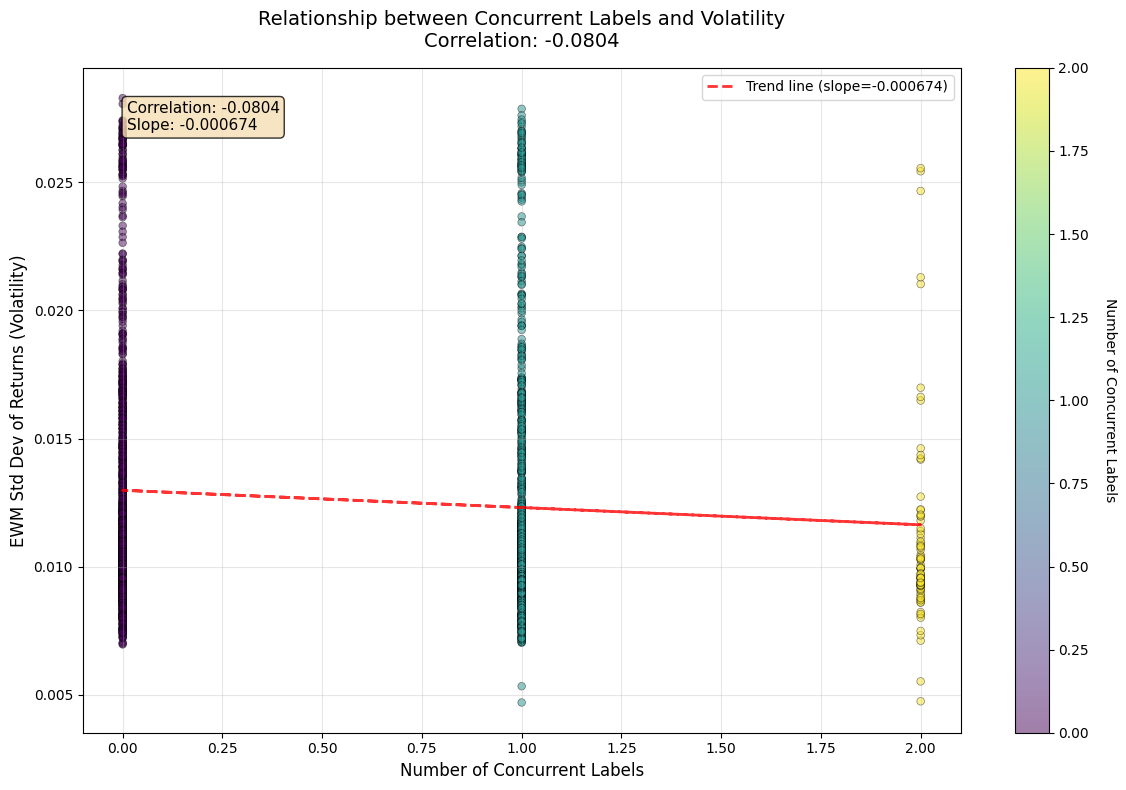


=== Statistical Analysis ===
Correlation coefficient: -0.0804
Trend line slope: -0.000674
Trend line intercept: 0.012981

Interpretation:
There is a weak negative relationship (r=-0.0804).
Higher volatility tends to be associated with fewer concurrent labels.


In [30]:
import matplotlib.pyplot as plt

# Create scatterplot of concurrent labels vs. EWM volatility
fig, ax = plt.subplots(figsize=(12, 8))

# Align the two series
dv_aligned = dv_dollar.reindex(concurrent_events.index, method='ffill')

# Create scatterplot
scatter = ax.scatter(concurrent_events.values, dv_aligned.values, 
                     alpha=0.5, s=30, c=concurrent_events.values, 
                     cmap='viridis', edgecolors='black', linewidth=0.5)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Number of Concurrent Labels', rotation=270, labelpad=20)

# Add trend line
z = np.polyfit(concurrent_events.values, dv_aligned.values, 1)
p = np.poly1d(z)
ax.plot(concurrent_events.values, p(concurrent_events.values), 
        "r--", alpha=0.8, linewidth=2, label=f'Trend line (slope={z[0]:.6f})')

# Calculate correlation
correlation = np.corrcoef(concurrent_events.values, dv_aligned.values)[0, 1]

# Labels and title
ax.set_xlabel('Number of Concurrent Labels', fontsize=12)
ax.set_ylabel('EWM Std Dev of Returns (Volatility)', fontsize=12)
ax.set_title(f'Relationship between Concurrent Labels and Volatility\nCorrelation: {correlation:.4f}', 
             fontsize=14, pad=15)
ax.grid(True, alpha=0.3)
ax.legend()

# Add text box with interpretation
textstr = f'Correlation: {correlation:.4f}\nSlope: {z[0]:.6f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

# Print statistical summary
print(f"\n=== Statistical Analysis ===")
print(f"Correlation coefficient: {correlation:.4f}")
print(f"Trend line slope: {z[0]:.6f}")
print(f"Trend line intercept: {z[1]:.6f}")
print(f"\nInterpretation:")
if abs(correlation) > 0.7:
    strength = "strong"
elif abs(correlation) > 0.4:
    strength = "moderate"
else:
    strength = "weak"

if correlation > 0:
    direction = "positive"
    meaning = "Higher volatility tends to be associated with more concurrent labels."
else:
    direction = "negative"
    meaning = "Higher volatility tends to be associated with fewer concurrent labels."

print(f"There is a {strength} {direction} relationship (r={correlation:.4f}).")
print(meaning)

## 2.	Using the function mpSampleTW, compute the average uniqueness of each label. 

What is the first-order serial correlation, AR(1), of this time series? 

Is it statistically significant?

Why?
